In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# be careful with that:
import warnings
warnings.filterwarnings('ignore')

In [8]:
data_heatmap = pd.read_csv('A_data_heatmap_300x250_3p.csv')
data_metrics = pd.read_csv('A_data_domain_perf_metrics_300x250_3p.csv')
data_metrics

,Unnamed: 0,domain,grid_id,webview_height,webview_width,displays,clicks,landed_clicks,non_bounced_clicks,closing_events,avg_last_second_framerate,sov_short_ttc,sov_short_ttc_global,sov_short_ttc_score
0,0,ID_1815,333519,250.0,300.0,2832,11.0,6.0,3.0,7.0,60.578947,0.002750,0.049334,-0.046584
1,1,ID_979,333519,250.0,300.0,2169,1.0,1.0,1.0,NaN,59.000000,NaN,NaN,NaN
2,2,ID_1413,333519,250.0,300.0,7077,16.0,2.0,0.0,5.0,31.333333,0.345627,0.185044,0.292426
3,3,ID_1408,333519,250.0,300.0,14106,22.0,17.0,2.0,NaN,56.500000,NaN,NaN,NaN
4,4,ID_1196,333519,250.0,300.0,2688,1.0,1.0,1.0,NaN,55.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5501,5501,ID_2786,333346,250.0,300.0,5691,6.0,6.0,5.0,3.0,60.583333,NaN,NaN,NaN
5502,5502,ID_2974,333346,250.0,300.0,152352,27.0,23.0,9.0,NaN,71.489362,0.012835,0.049334,-0.036499
5503,5503,ID_385,333346,250.0,300.0,96687,42.0,33.0,12.0,1.0,66.844444,0.010152,0.053200,-0.039182
5504,5504,ID_3557,333346,250.0,300.0,1011320,475.0,405.0,263.0,48.0,73.767480,0.069024,0.053200,0.019690


In [111]:
# Filter the data for 'grid_id' = 333519
data_filtered = data_metrics[data_metrics['grid_id'] == 333519].copy()

domain_ids = data_filtered['domain'].copy()

data_for_clustering = data_filtered.drop(columns=['grid_id','domain'])

# Replace NaN values with the mean of each column
## could be improved
data_for_clustering.fillna(data_for_clustering.mean(), inplace=True)

# Normalize the numerical data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_for_clustering)

In [112]:
# Binning clicks in nr_of_x_bins, nr_of_y_bins:

NR_OF_X_BINS = 61 # number of bins
NR_OF_Y_BINS = 51

max_width = data_heatmap['display_width'].max() #300
max_height = data_heatmap['display_height'].max() #250

width_bins = np.linspace(1, max_width, NR_OF_X_BINS)
height_bins = np.linspace(1, max_height, NR_OF_Y_BINS)

width_bins_max = len(width_bins)-2 # start at 0
height_bins_max = len(height_bins)-2

data_heatmap['click_x_bin'] = pd.cut(data_heatmap['click_x'],   # bin nearby x clicks together
                                      bins = width_bins, 
                                      labels=False, 
                                      include_lowest=True)

data_heatmap['click_y_bin'] = pd.cut(data_heatmap['click_y'], 
                                      bins=height_bins, 
                                      labels=False, 
                                      include_lowest=True)

aggregated_clicks = data_heatmap.groupby(['grid_id',
                                           'domain', 
                                           'click_x_bin', 
                                           'click_y_bin'])['clicks'].sum().reset_index(name='clicks_sum')

In [128]:
# Apply K-means clustering, k=3
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(data_normalized)

# Attach the cluster labels to the domain information
domain = domain_ids.to_frame()
domain['cluster'] = kmeans.labels_
domain.cluster.value_counts()

0    2879
2      61
1       1
Name: cluster, dtype: int64

In [129]:
anomaly = domain[domain['cluster'] == 1].domain
anomaly

2536    ID_1501
Name: domain, dtype: object

In [126]:
def plot_anomaly(n_rows, n_cols, anomaly, grid_id):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))  # Adjust the figure size as needed
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between plots

    plot_count = 0

    for domain in anomaly:
        ex = aggregated_clicks[(aggregated_clicks.grid_id == grid_id) &
                            (aggregated_clicks.domain == domain)]
        if len(ex) == 0: # skips the entries that are not in heatmap data 
            continue

        click_matrix = ex.pivot("click_y_bin", "click_x_bin", "clicks_sum").fillna(0)
        
        if plot_count == n_rows * n_cols:  # Check if the figure is full
            #plt.savefig(f'heatmap_combined_{idx}.png', bbox_inches='tight')  # Save current figure
            plt.show()
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))  # Start a new figure
            fig.subplots_adjust(hspace=0.4, wspace=0.4)
            plot_count = 0  # Reset plot count for the new figure

        row = plot_count // n_cols
        col = plot_count % n_cols
        
        ax = axes[row, col]
        sns.heatmap(click_matrix, 
                    cmap="YlGnBu", 
                    annot=False, 
                    cbar=True, 
                    fmt="g", 
                    ax=ax)
        ax.set_title(f'Click Heatmap for grid = {grid_id} and domain = {domain}')
        ax.set_xlabel('click_x Bin')
        ax.set_ylabel('click_y Bin')
        ax.invert_yaxis()
        
        plot_count += 1

    if plot_count > 0:
    #    plt.savefig(f'heatmap_combined_final.png', bbox_inches='tight')
        plt.show()

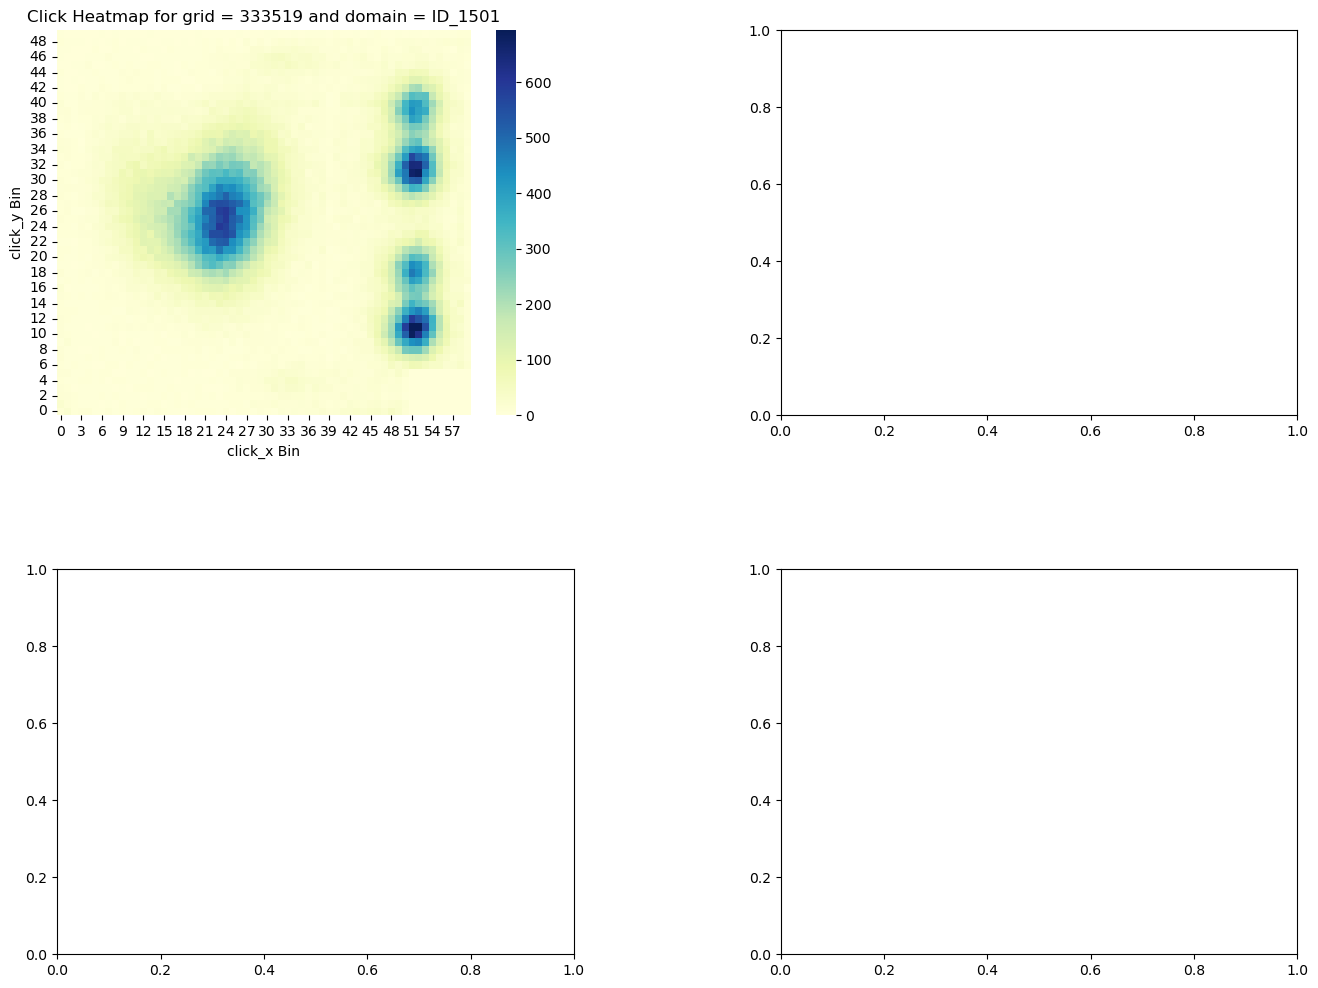

In [134]:
plot_anomaly(2,2,anomaly,333519)  # This is actually a very normal heatmap

In [100]:
# Apply K-means clustering, k=4
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(data_normalized)

# Attach the cluster labels to the domain information
domain = domain_ids.to_frame()
domain['cluster'] = kmeans.labels_
domain.cluster.value_counts()

1    1484
0    1395
3      61
2       1
Name: cluster, dtype: int64

In [119]:
anomaly = domain[domain['cluster'] == 3].domain
anomaly


2       ID_1413
57       ID_162
99       ID_484
131      ID_398
473     ID_1615
         ...   
4880     ID_561
5088    ID_2097
5285    ID_2153
5294    ID_3420
5411    ID_2780
Name: domain, Length: 61, dtype: object

In [114]:
# some grid_id and domain in metrics data don't exist in heatmap data
aggregated_clicks[(aggregated_clicks.grid_id == 333519) & (aggregated_clicks.domain == 'ID_1413')]

,grid_id,domain,click_x_bin,click_y_bin,clicks_sum


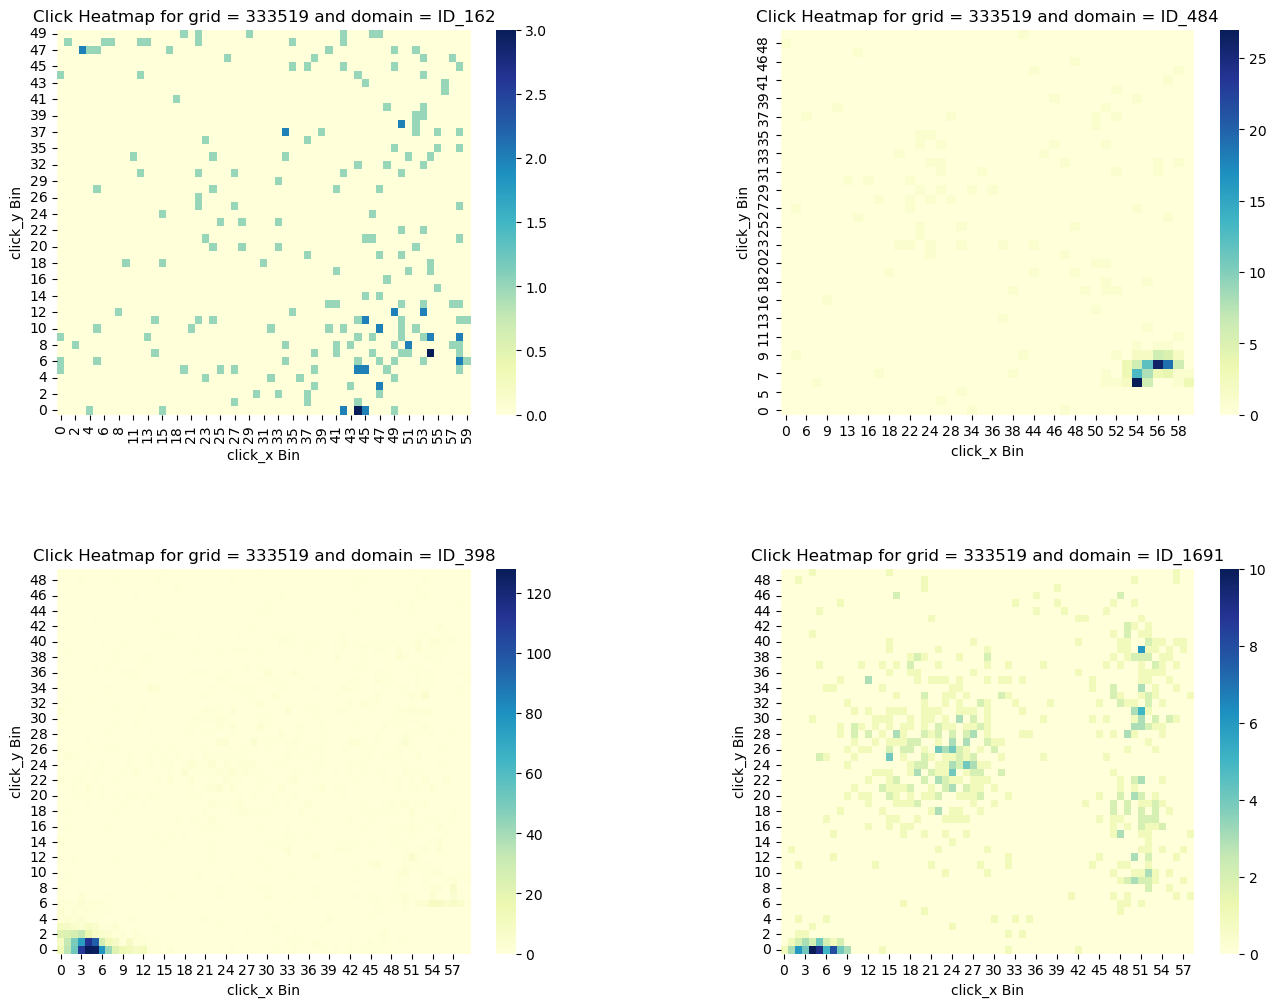

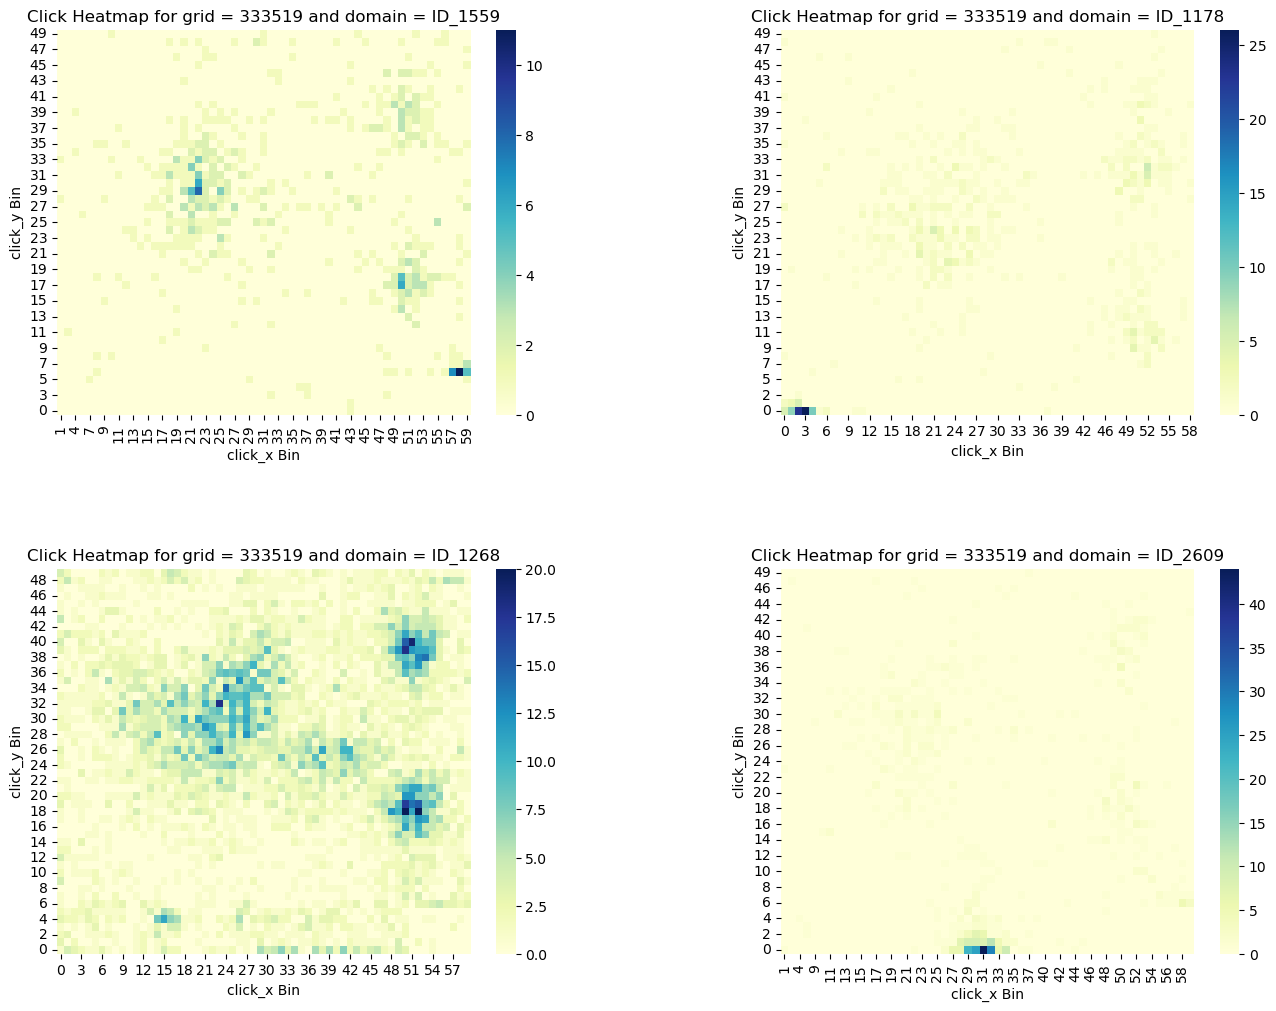

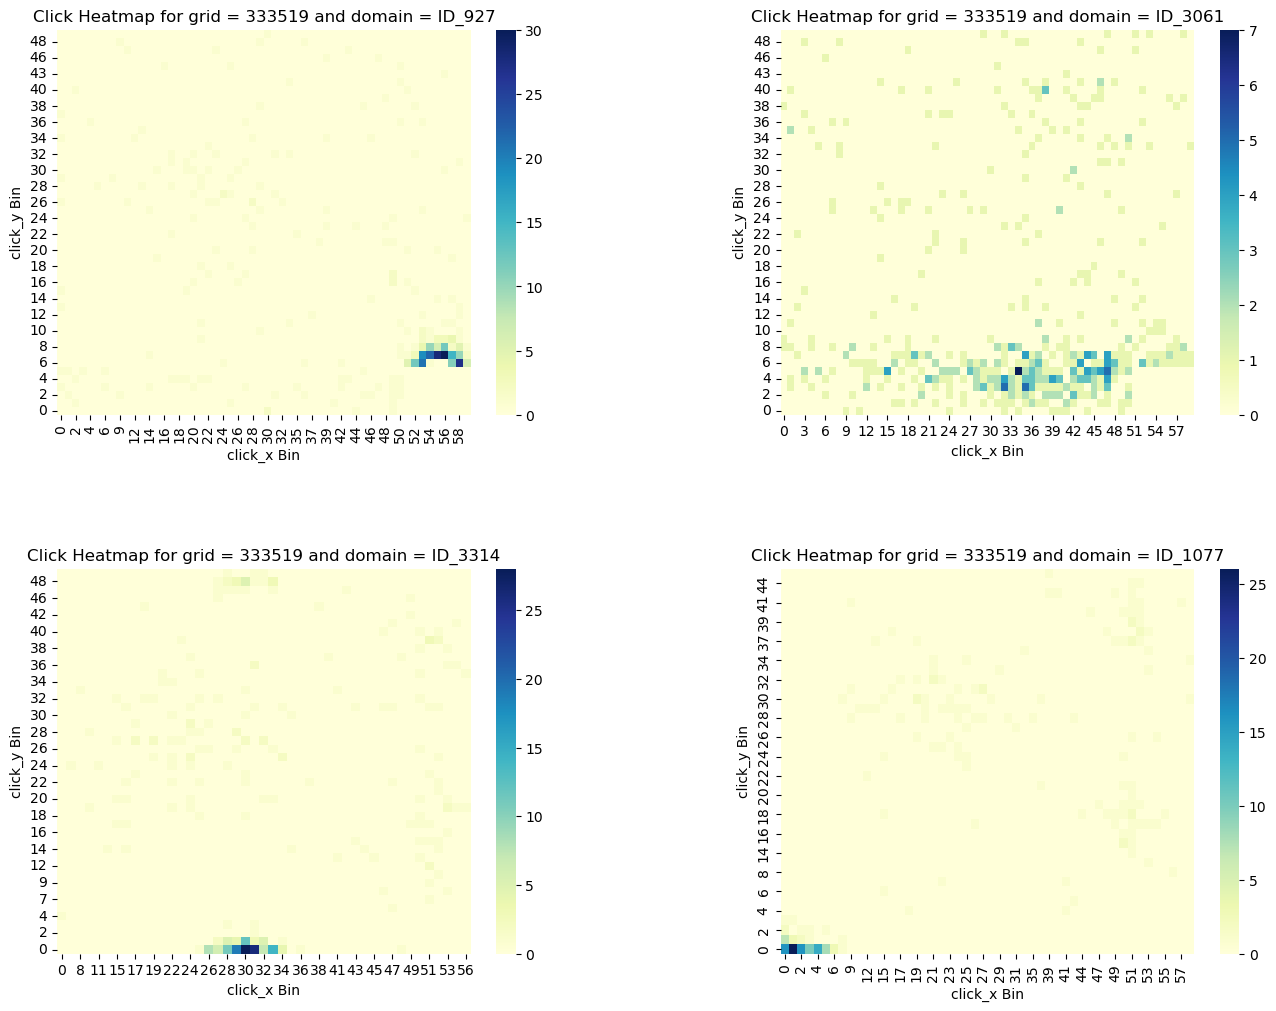

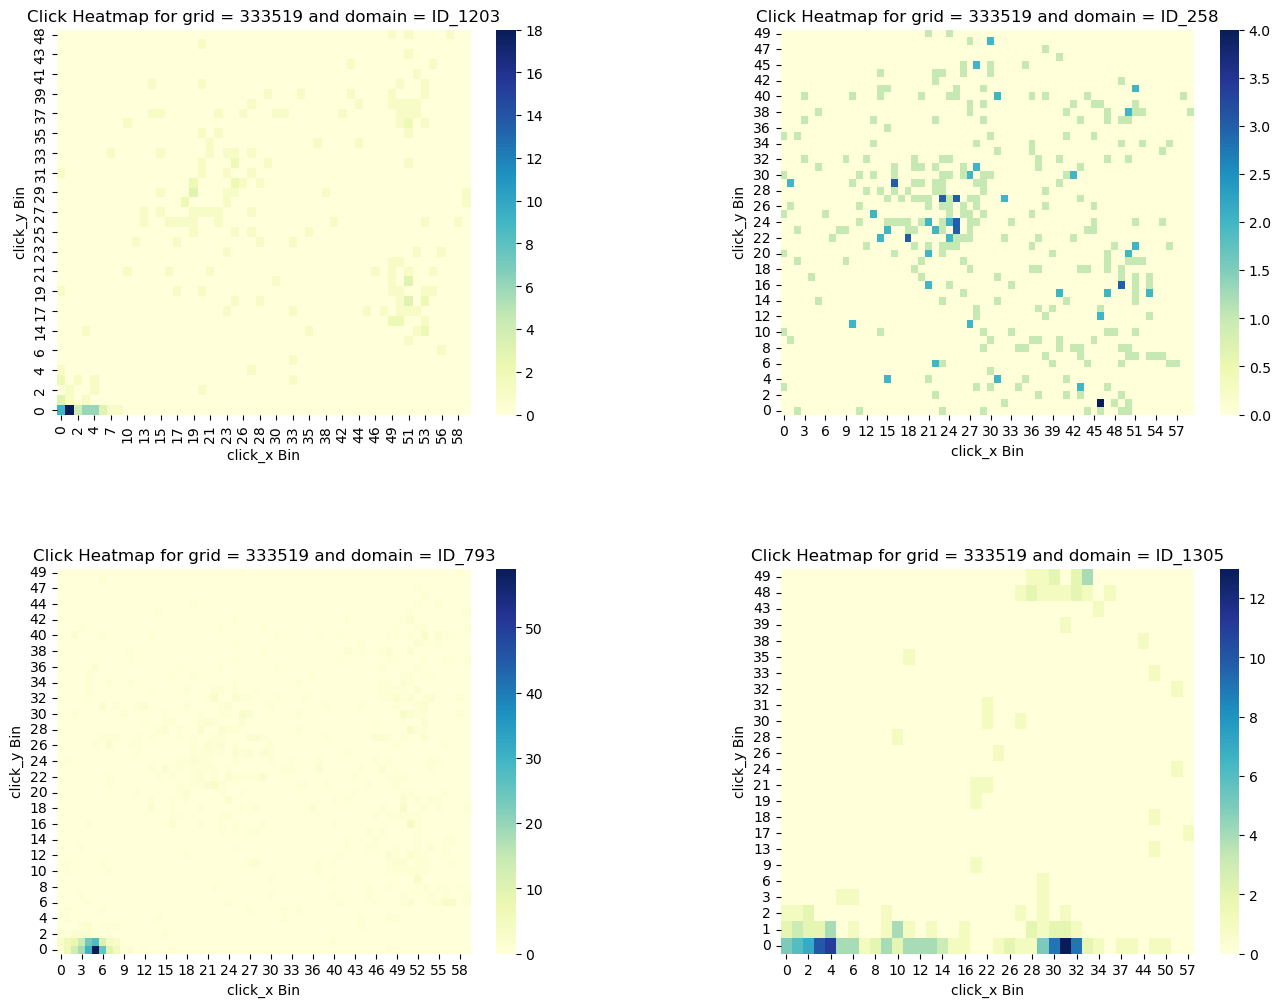

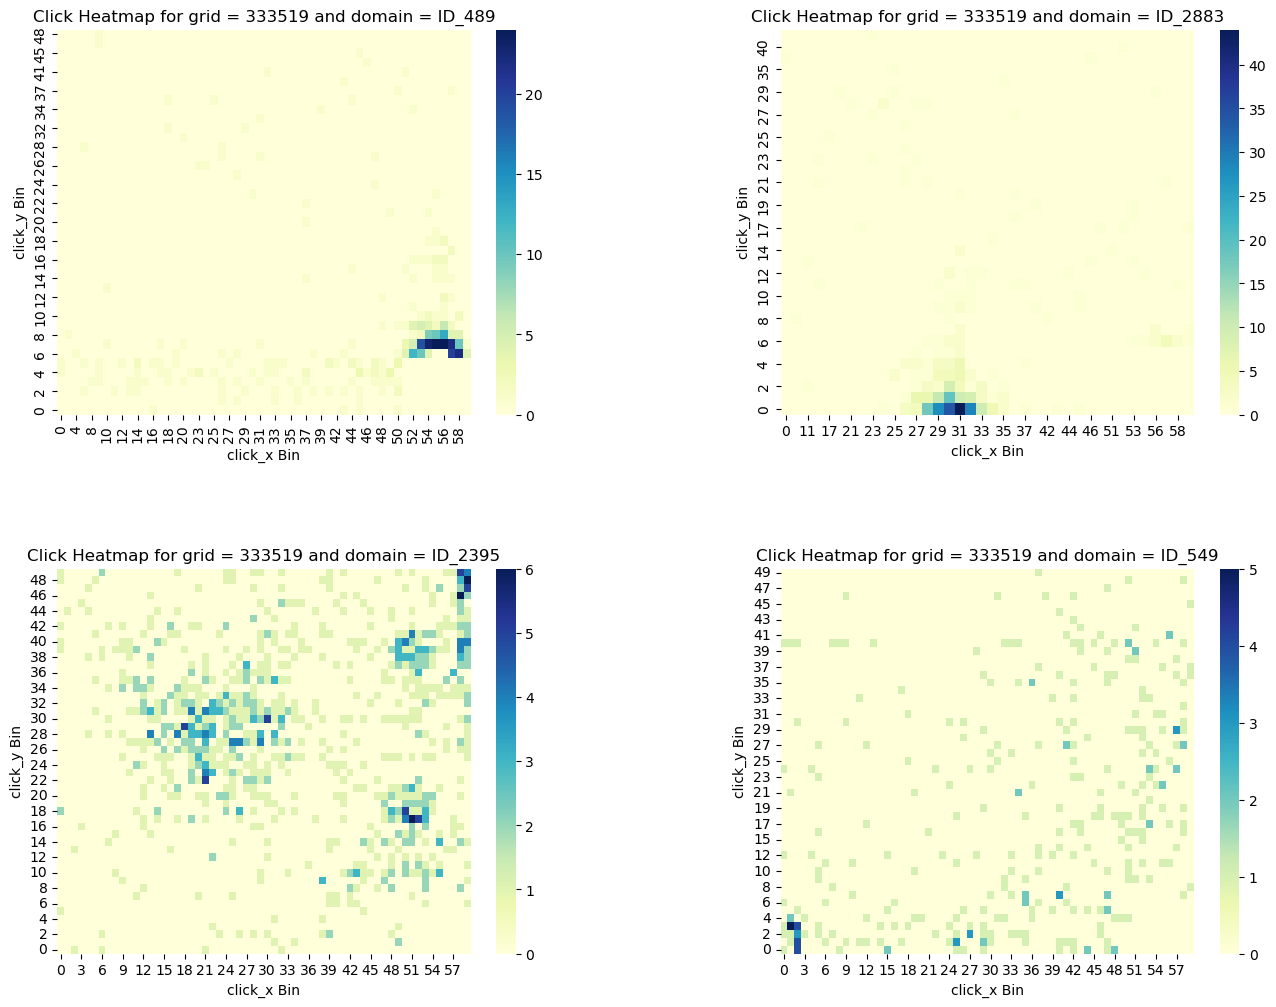

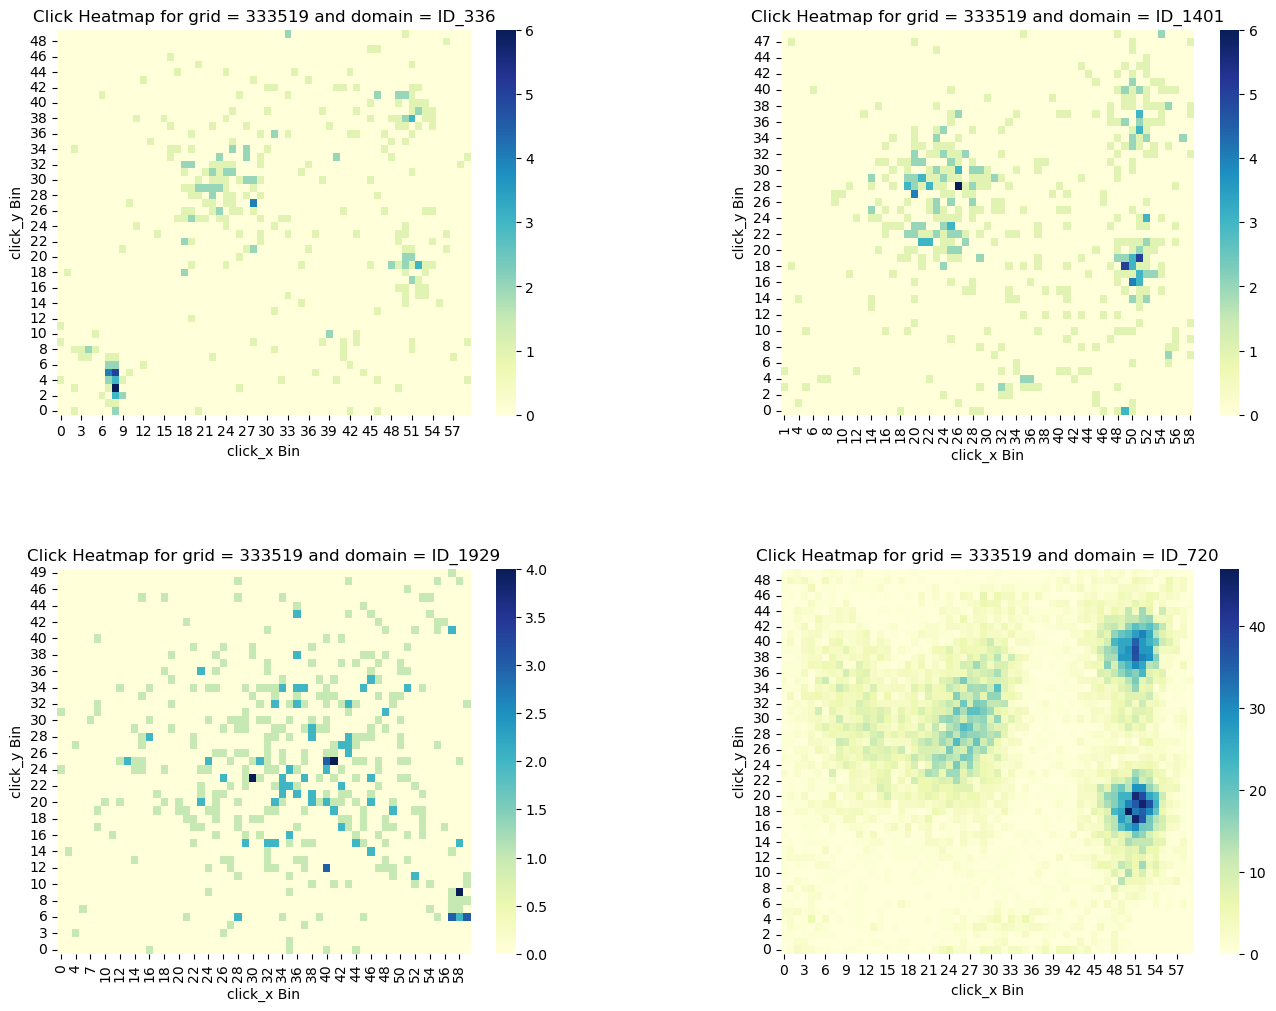

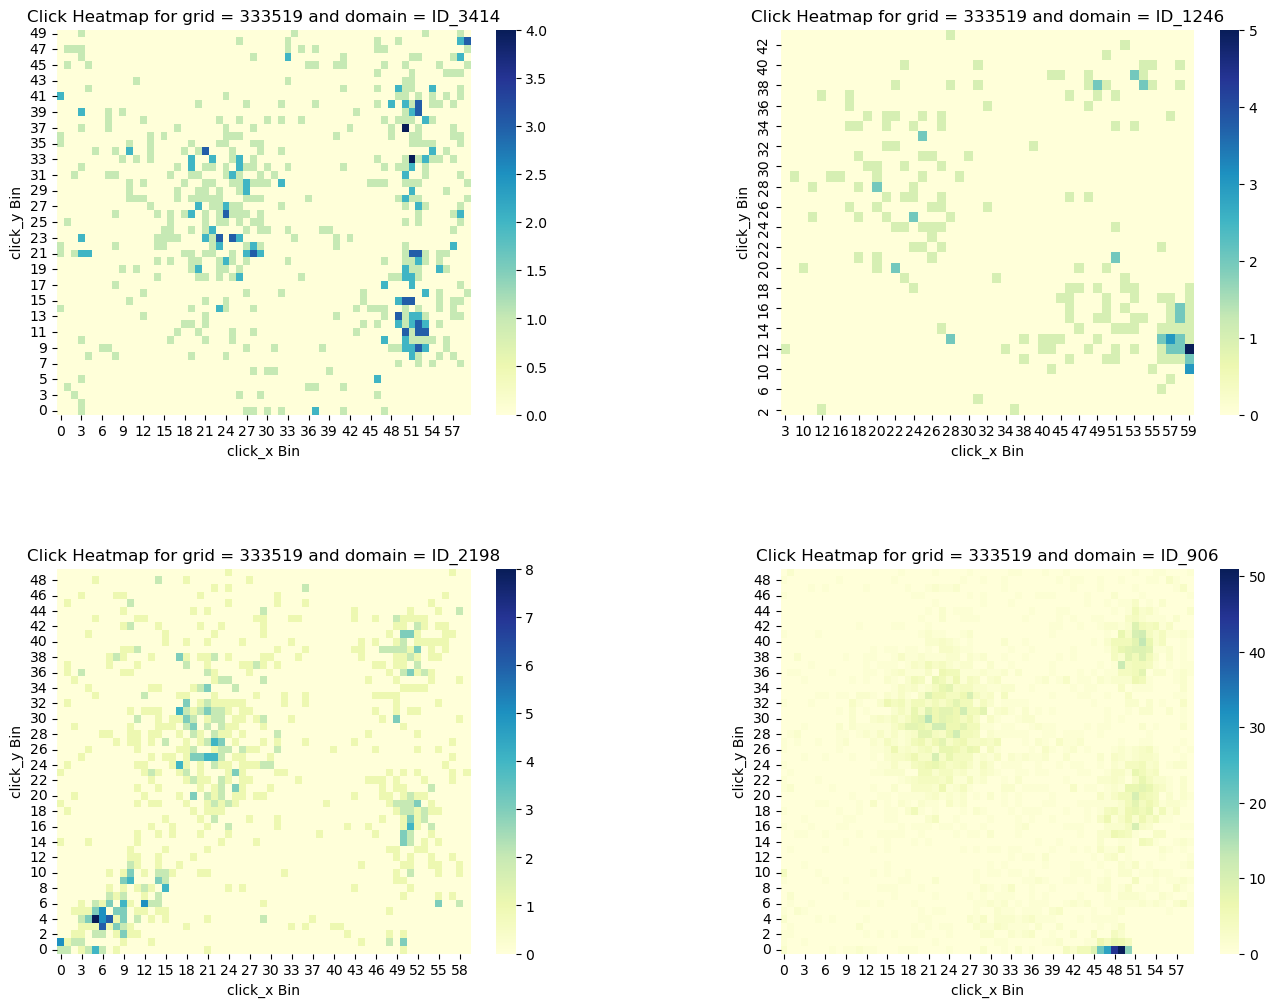

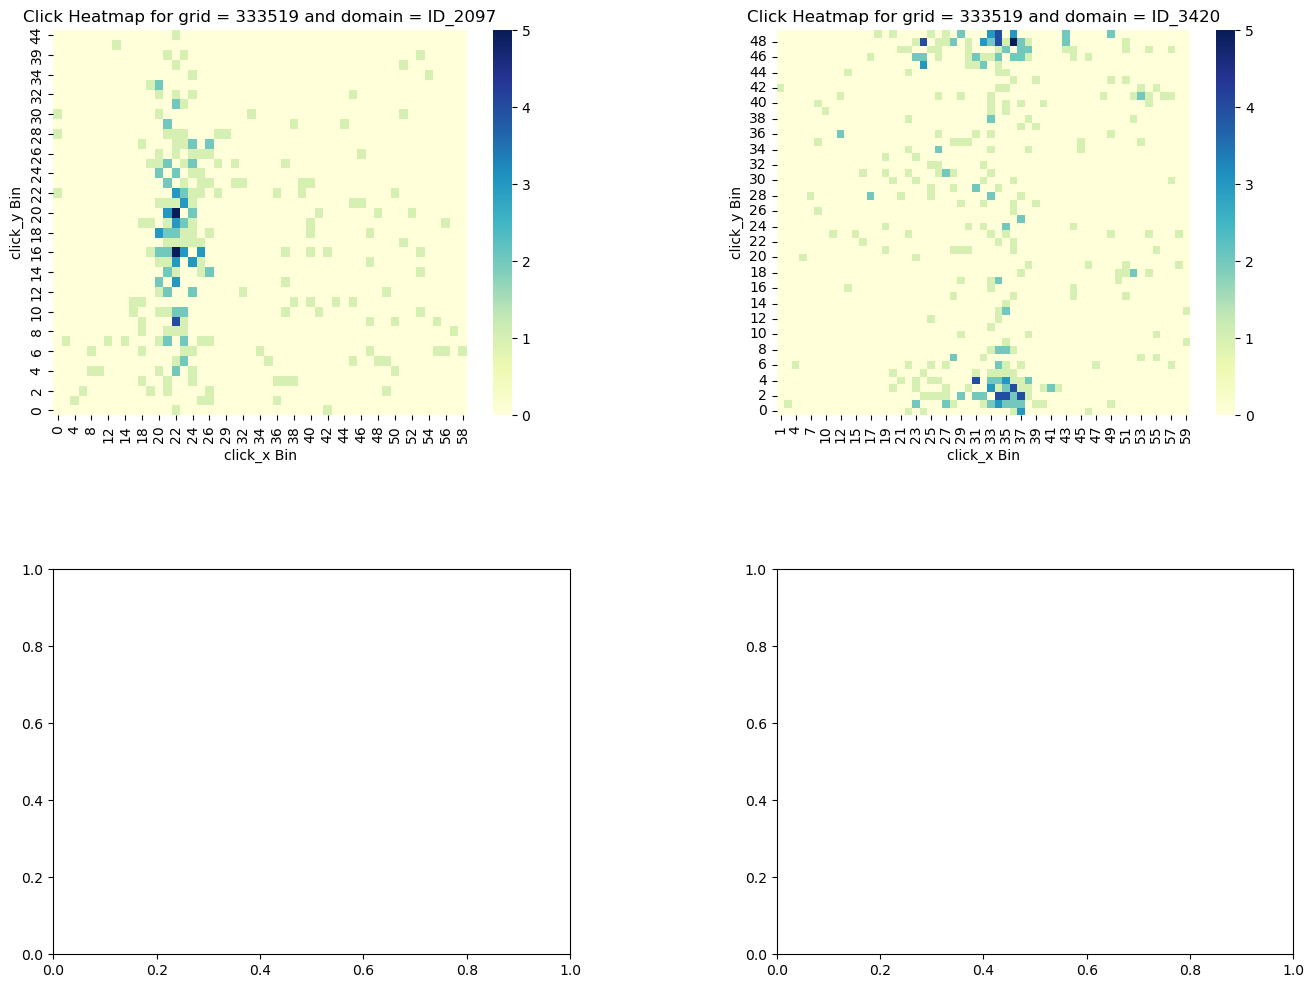

In [127]:
plot_anomaly(2,2,anomaly,333519)